In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from collections import Counter
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE,  ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Fraud_check.csv to Fraud_check.csv


In [4]:
fraud_check = pd.read_csv("Fraud_check.csv")
fraud_check.head(10)

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
5,NO,Divorced,33329,116382,0,NO
6,NO,Divorced,83357,80890,8,YES
7,YES,Single,62774,131253,3,YES
8,NO,Single,83519,102481,12,YES
9,YES,Divorced,98152,155482,4,YES


In [6]:
fraud_check.isnull().any

<bound method NDFrame._add_numeric_operations.<locals>.any of      Undergrad  Marital.Status  Taxable.Income  City.Population  \
0        False           False           False            False   
1        False           False           False            False   
2        False           False           False            False   
3        False           False           False            False   
4        False           False           False            False   
..         ...             ...             ...              ...   
595      False           False           False            False   
596      False           False           False            False   
597      False           False           False            False   
598      False           False           False            False   
599      False           False           False            False   

     Work.Experience  Urban  
0              False  False  
1              False  False  
2              False  False  
3            

In [7]:
fraud_check.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [8]:
fraud_check.shape

(600, 6)

In [9]:
fraud_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [10]:
fraud_check.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


In [11]:
fraud_check[fraud_check.duplicated()].shape

(0, 6)

In [12]:
fraud_check['Taxable.Income'].describe()

count      600.000000
mean     55208.375000
std      26204.827597
min      10003.000000
25%      32871.500000
50%      55074.500000
75%      78611.750000
max      99619.000000
Name: Taxable.Income, dtype: float64



*   Taxable Income <=30000 as Risky=0
*   Taxable Income >=30000 as Good= 1



In [14]:
fraud_check_new = fraud_check.copy()
fraud_check_new['Taxable.Category'] = pd.cut(x = fraud_check_new['Taxable.Income'],bins = [10002,30000,99620],labels=['Risky','Good'] )
fraud_check_new.head(10)

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,Taxable.Category
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good
5,NO,Divorced,33329,116382,0,NO,Good
6,NO,Divorced,83357,80890,8,YES,Good
7,YES,Single,62774,131253,3,YES,Good
8,NO,Single,83519,102481,12,YES,Good
9,YES,Divorced,98152,155482,4,YES,Good


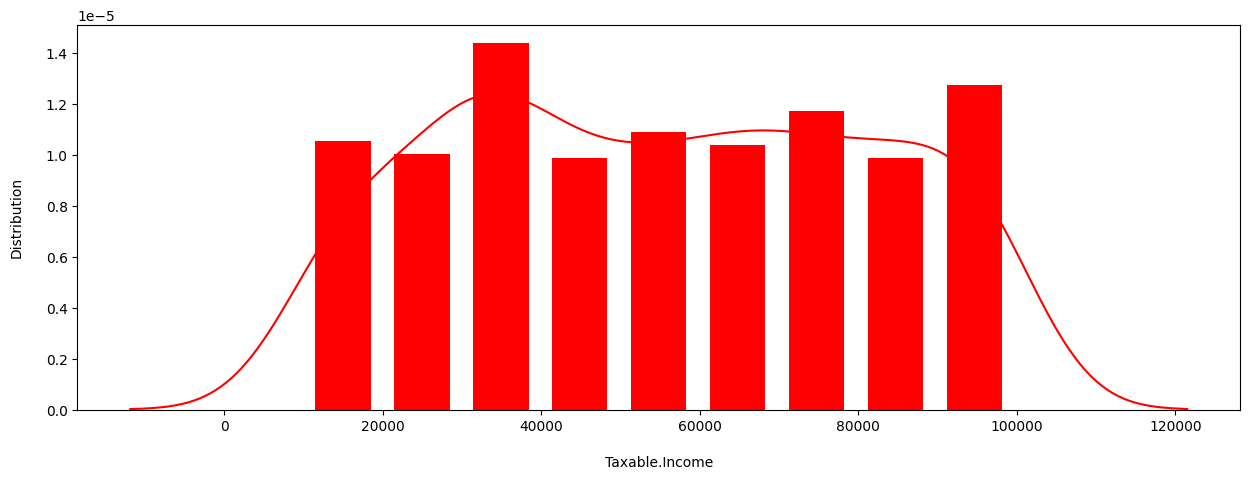

In [17]:
def distplot(params):
    plt.figure(figsize= (15,5))
    sns.distplot(fraud_check[params], color= "red", hist_kws={"rwidth":0.70, 'alpha':1.0})
    plt.xlabel('\n'+params)
    plt.ylabel('Distribution\n')
    plt.show()
distplot("Taxable.Income")

In [18]:
fraud_check_new['Taxable.Category'].value_counts()

Good     476
Risky    124
Name: Taxable.Category, dtype: int64

In [19]:
fraud_check_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Undergrad         600 non-null    object  
 1   Marital.Status    600 non-null    object  
 2   Taxable.Income    600 non-null    int64   
 3   City.Population   600 non-null    int64   
 4   Work.Experience   600 non-null    int64   
 5   Urban             600 non-null    object  
 6   Taxable.Category  600 non-null    category
dtypes: category(1), int64(3), object(3)
memory usage: 29.0+ KB


In [20]:
Categorical_features = fraud_check_new.describe(include=['object']).columns
Categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')

In [21]:
Numerical_features = fraud_check_new.describe(include=['int64']).columns
Numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

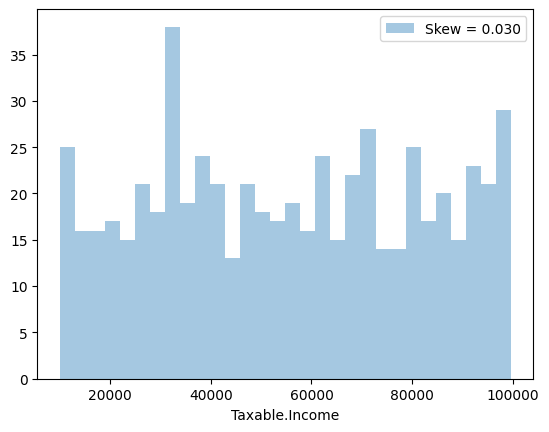

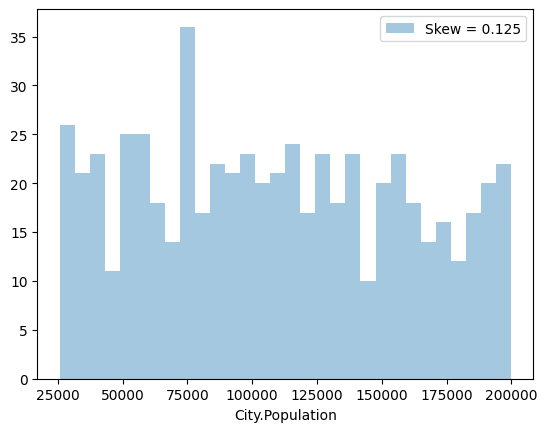

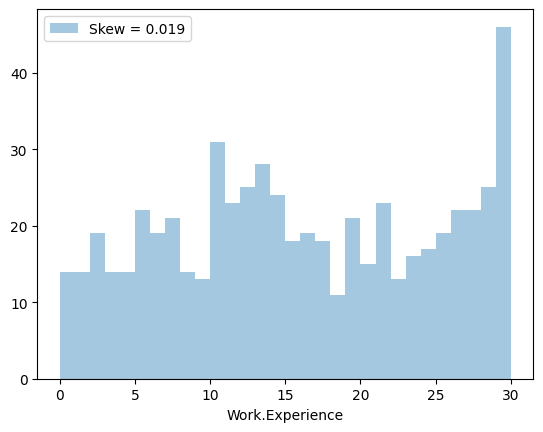

In [22]:
#Univariate Plots

Numerical_features=[feature for feature in fraud_check.columns if fraud_check[feature].dtypes != 'O']
for feat in Numerical_features:
    skew = fraud_check[feat].skew()
    sns.distplot(fraud_check[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [23]:
#Outliers

Numerical_features

['Taxable.Income', 'City.Population', 'Work.Experience']

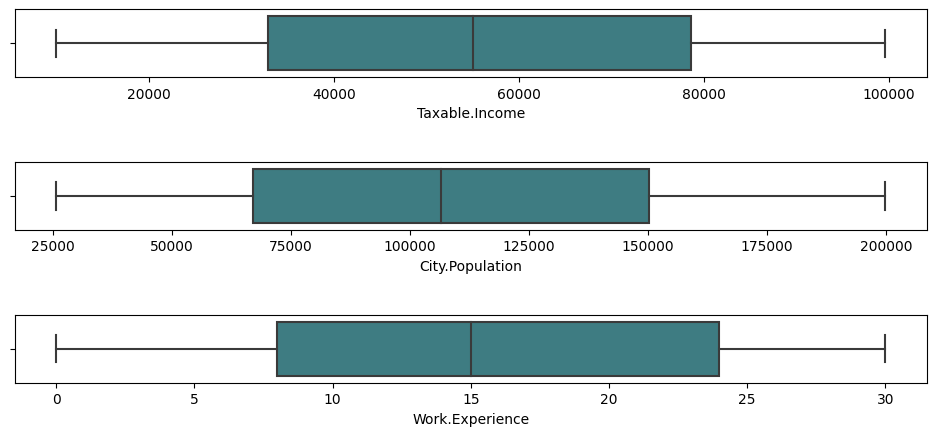

In [24]:
Outliers = fraud_check.copy() 
fig, axes = plt.subplots(3,1,figsize=(10,5),sharex=False,sharey=False)
sns.boxplot(x='Taxable.Income',data= Outliers,palette='crest',ax=axes[0])
sns.boxplot(x='City.Population',data= Outliers,palette='crest',ax=axes[1])
sns.boxplot(x='Work.Experience',data= Outliers,palette='crest',ax=axes[2])
plt.tight_layout(pad=3.0)

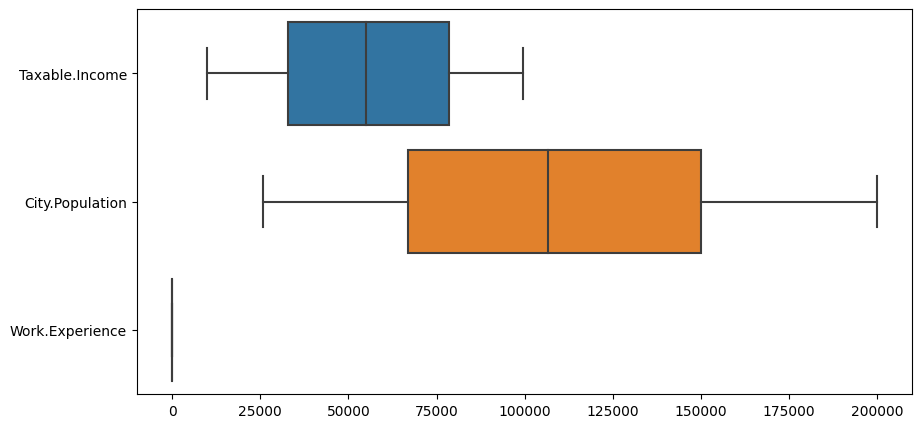

In [26]:
plt.figure(figsize=(10,5))
sns.boxplot(data= fraud_check[Numerical_features], orient="h")
plt.show()

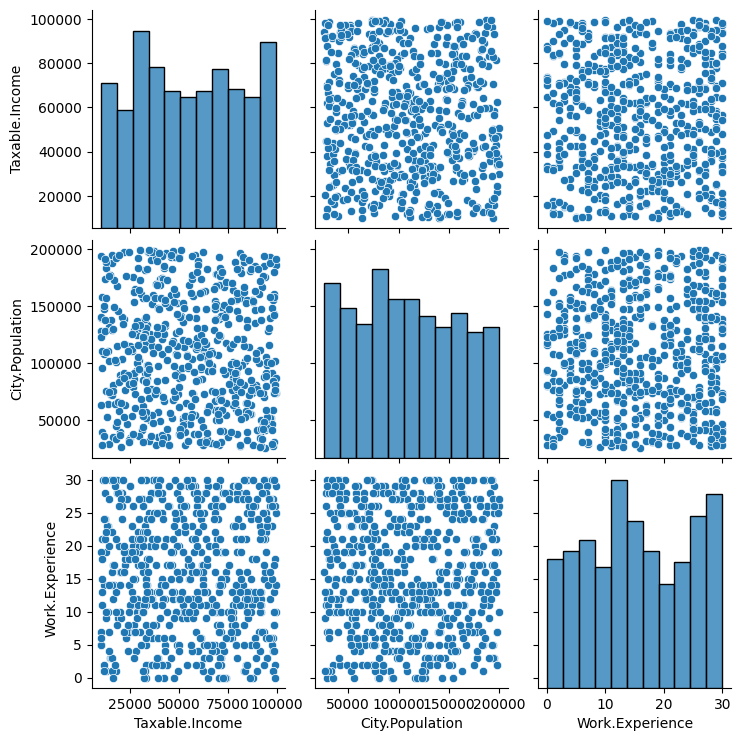

In [27]:
#Multivariate Analysis

sns.pairplot(fraud_check , palette='coolwarm')
plt.show()

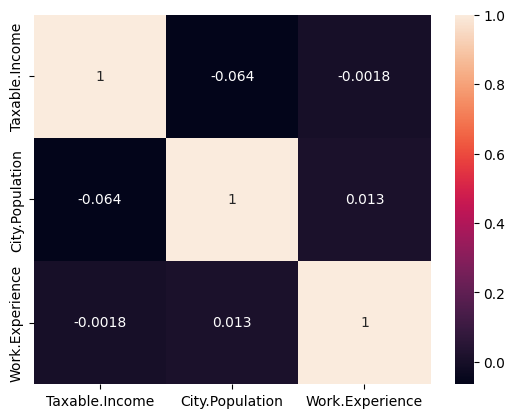

In [28]:
#Correlation Matrix
sns.heatmap(fraud_check.corr(), annot=True)
plt.show()

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')


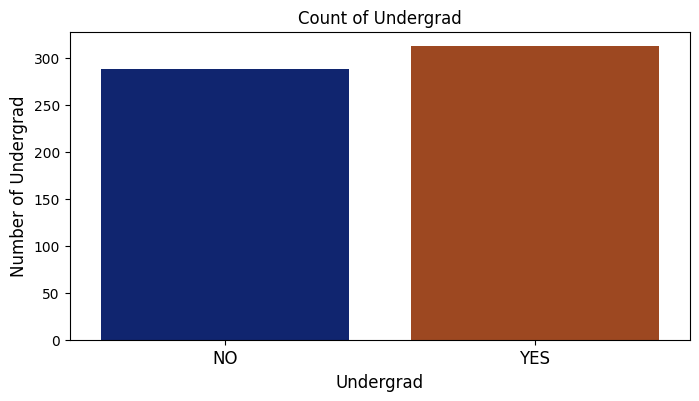

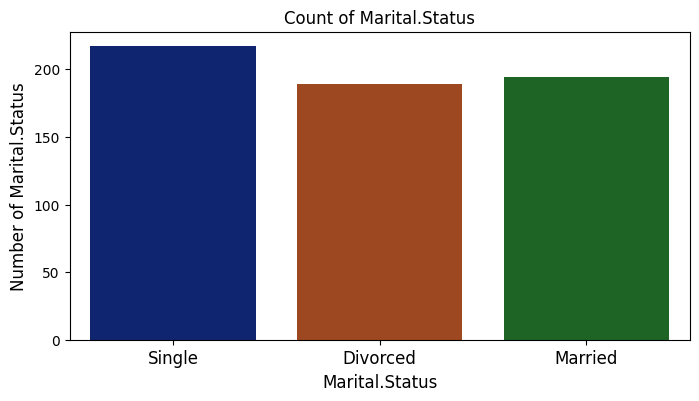

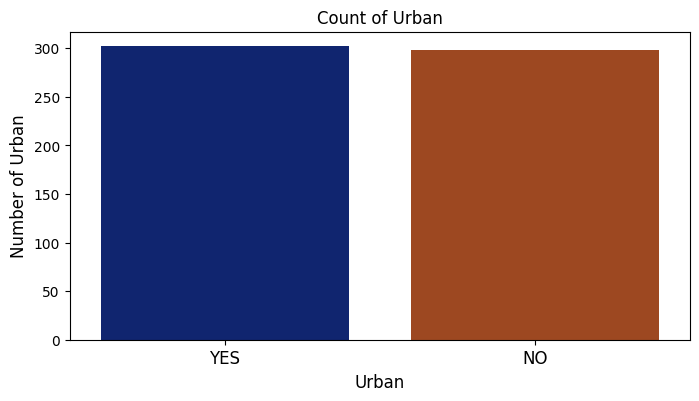

In [29]:
print(Categorical_features)

for idx, column in enumerate(Categorical_features):
    plt.figure(figsize=(8,4))
    unique = fraud_check[column].value_counts(ascending=True);
   
    plt.title("Count of "+ column)
    sns.countplot(data= fraud_check_new, x=column, palette = "dark")
    plt.xticks(rotation = 0, size = 12)
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)

In [34]:
def catplot(params):
    sns.catplot(x= params, size= 5, aspect= 2, data= fraud_check, y= "Taxable.Income", palette= "dark")
    plt.xlabel("\n" + params)
    plt.ylabel("Taxable Income\n")
    plt.show()

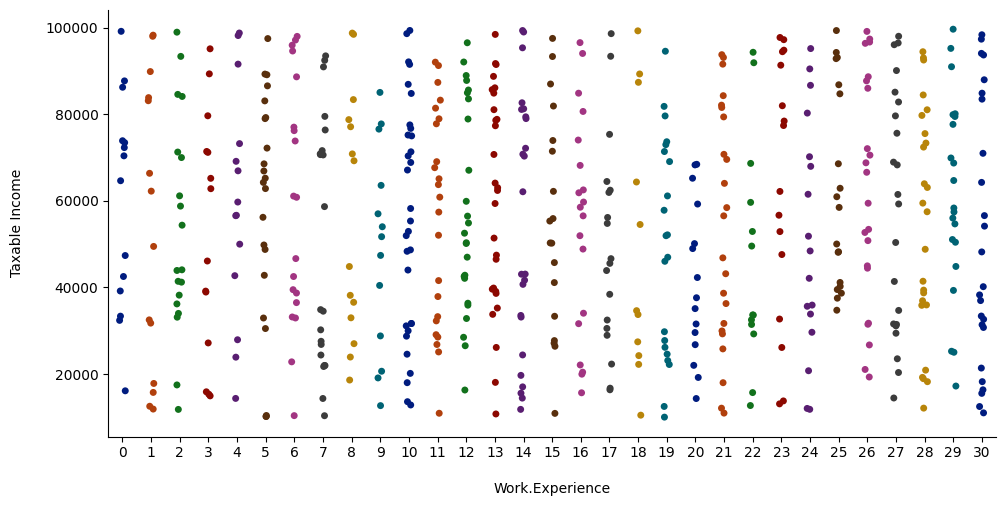

In [35]:
catplot("Work.Experience")

## **Pair Plot to Visualise All Attribute Once**

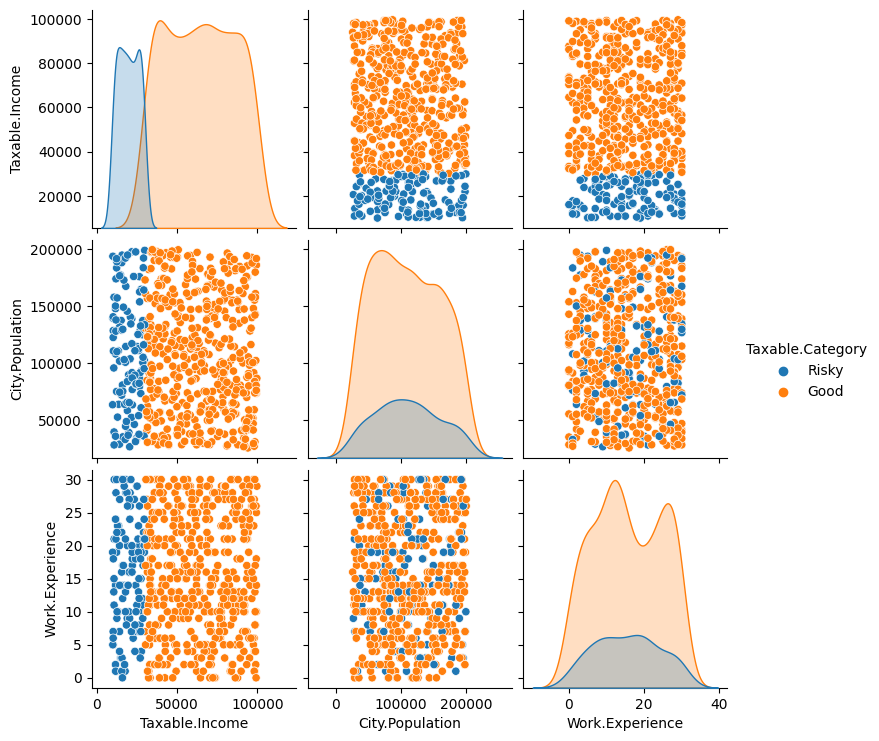

In [36]:
sns.pairplot(data = fraud_check_new, hue = "Taxable.Category")
plt.show()

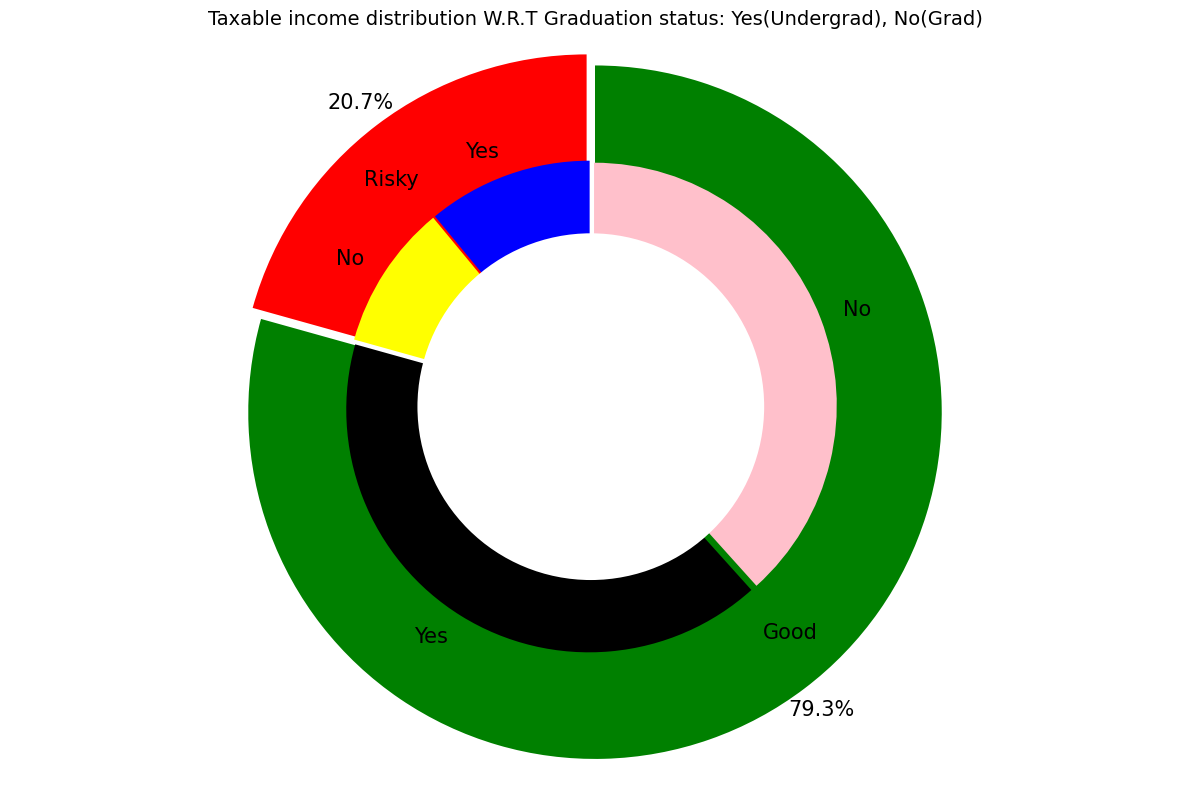

In [40]:
plt.figure(figsize=(12,8))
labels =["Risky", "Good"]
values = [fraud_check_new["Taxable.Category"][fraud_check_new["Taxable.Category"] == 'Risky'].groupby(by = fraud_check_new.Undergrad).count().sum(),
         fraud_check_new["Taxable.Category"][fraud_check_new["Taxable.Category"] == 'Good'].groupby(by = fraud_check_new.Undergrad).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [66,58 , 246,230]
colors = ['Red', 'green']
colors_gender = ['blue','yellow','black', 'pink']
explode = (0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15, 'rotation':0}

#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )

#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution W.R.T Graduation status: Yes(Undergrad), No(Grad)', fontsize= 14)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

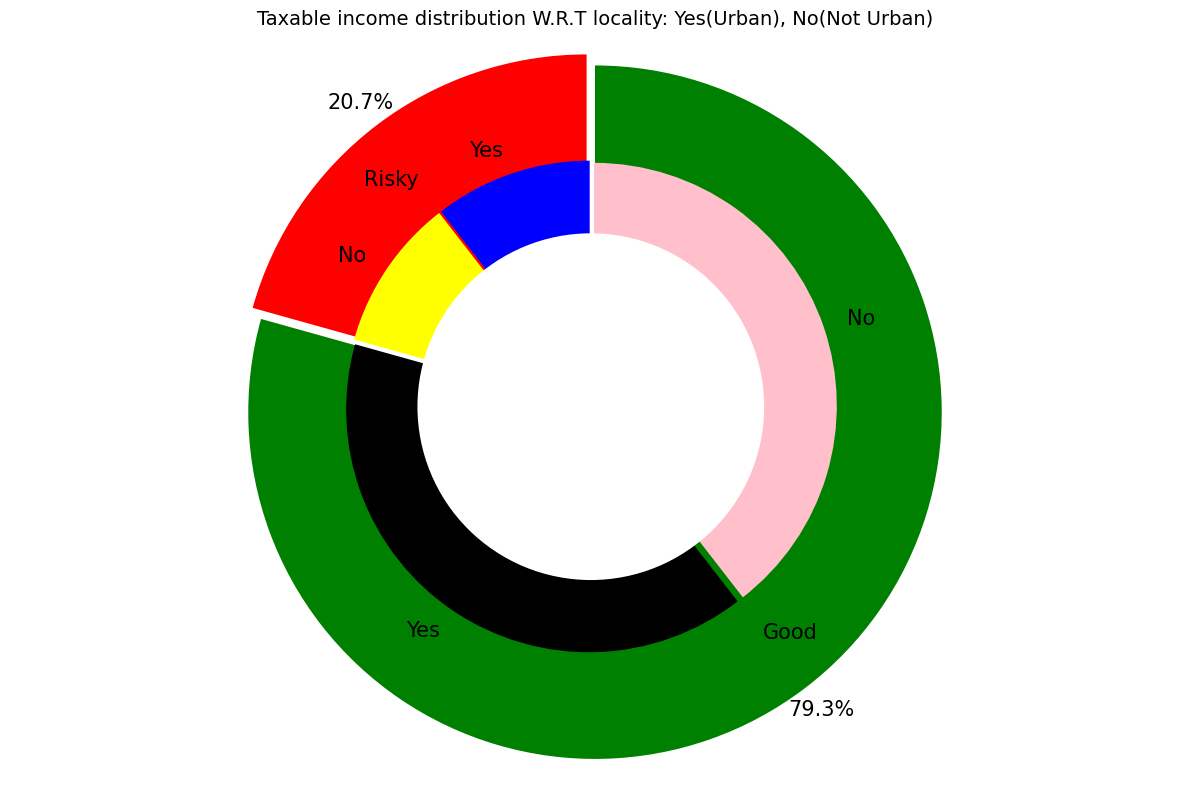

In [39]:
plt.figure(figsize=(12,8))
labels =["Risky", "Good"]
values = [fraud_check_new["Taxable.Category"][fraud_check_new["Taxable.Category"] == 'Risky'].groupby(by = fraud_check_new["Urban"]).count().sum(),
         fraud_check_new["Taxable.Category"][fraud_check_new["Taxable.Category"] == 'Good'].groupby(by = fraud_check_new["Urban"]).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [63,61 , 239,237]
colors = ['Red', 'Green']
colors_gender = ['blue','yellow','black', 'pink']
explode = (0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15, 'rotation':0}

#Plot
plt.pie(values, labels=labels, autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )

#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution W.R.T locality: Yes(Urban), No(Not Urban)', fontsize=14)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

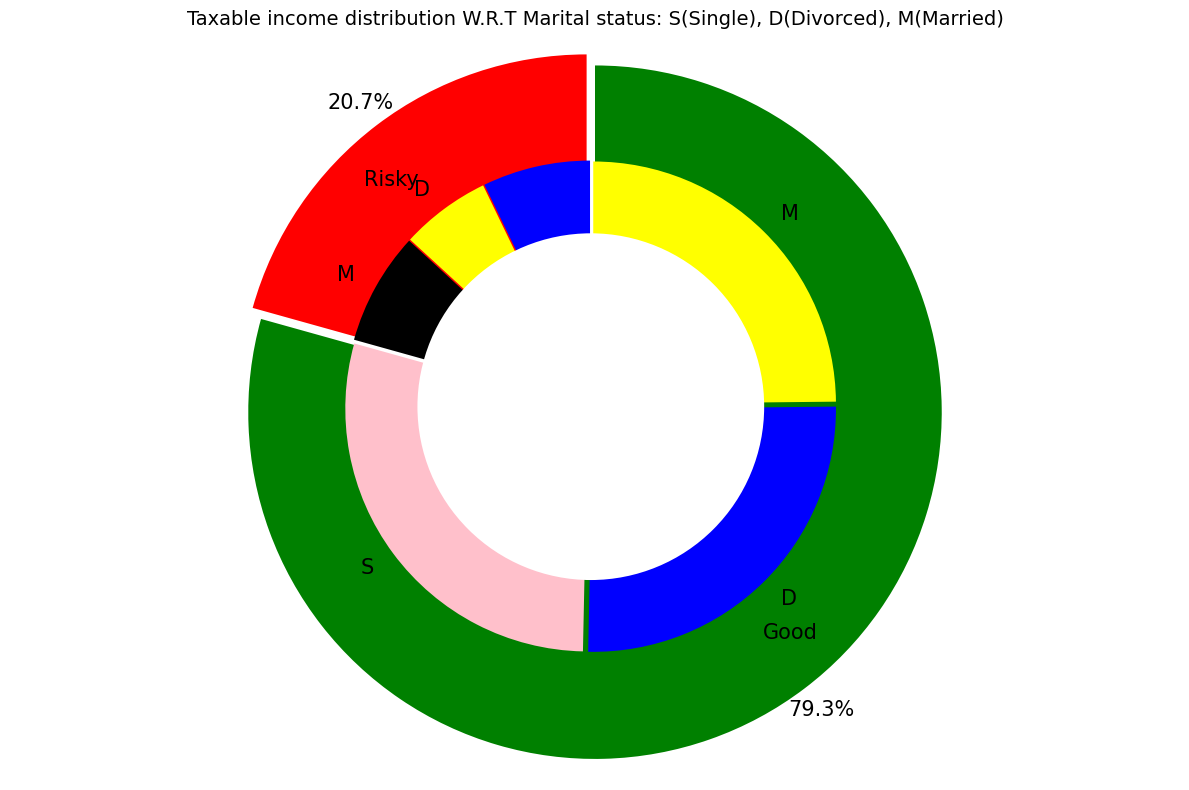

In [41]:
plt.figure(figsize=(12,8))
labels =["Risky", "Good"]
values = [fraud_check_new["Taxable.Category"][fraud_check_new["Taxable.Category"] == 'Risky'].groupby(by = fraud_check_new["Marital.Status"]).count().sum(),
         fraud_check_new["Taxable.Category"][fraud_check_new["Taxable.Category"] == 'Good'].groupby(by = fraud_check_new["Marital.Status"]).count().sum()]
labels_gender = ["","D","M","S","D", "M"]
sizes_gender = [43,36,45,174,153,149]
colors = ['Red', 'Green']
colors_gender = ['blue','yellow','black', 'pink']
explode = (0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1,0.1,0.1)
textprops = {"fontsize":15, 'rotation':'horizontal'}

#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )

#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution W.R.T Marital status: S(Single), D(Divorced), M(Married)', fontsize=14)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

In [42]:
fraud_check_dummi = fraud_check_new.copy()
fraud_check_dummi.drop(['Taxable.Income'],axis=1, inplace =True)
fraud_check_dummi = pd.get_dummies(fraud_check_dummi.iloc[:,:-1])
fraud_check_dummi.head(10)

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,1,0,0,0,1,0,1
1,134075,18,0,1,1,0,0,0,1
2,160205,30,1,0,0,1,0,0,1
3,193264,15,0,1,0,0,1,0,1
4,27533,28,1,0,0,1,0,1,0
5,116382,0,1,0,1,0,0,1,0
6,80890,8,1,0,1,0,0,0,1
7,131253,3,0,1,0,0,1,0,1
8,102481,12,1,0,0,0,1,0,1
9,155482,4,0,1,1,0,0,0,1


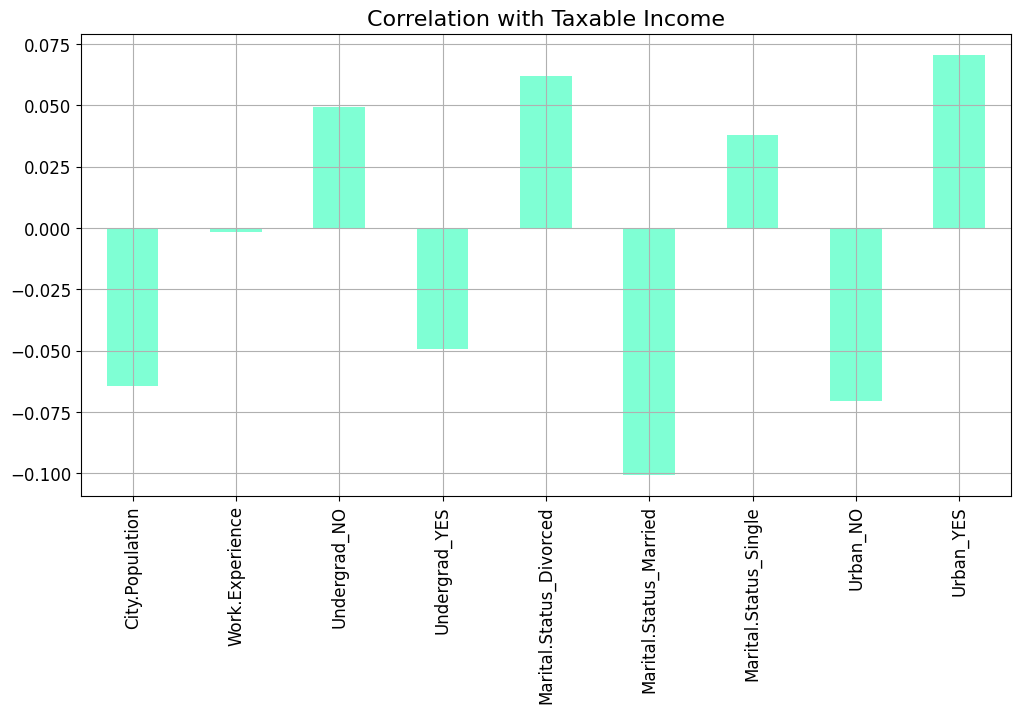

In [43]:
fraud_check_new1 = fraud_check_dummi.copy()

correlations = fraud_check_new1.corrwith(fraud_check_new['Taxable.Income'])                                     
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(figsize = (12,6), fontsize = 12, color = 'aquamarine', rot = 90, grid = True)
plt.title('Correlation with Taxable Income',fontsize = "16")
plt.show()

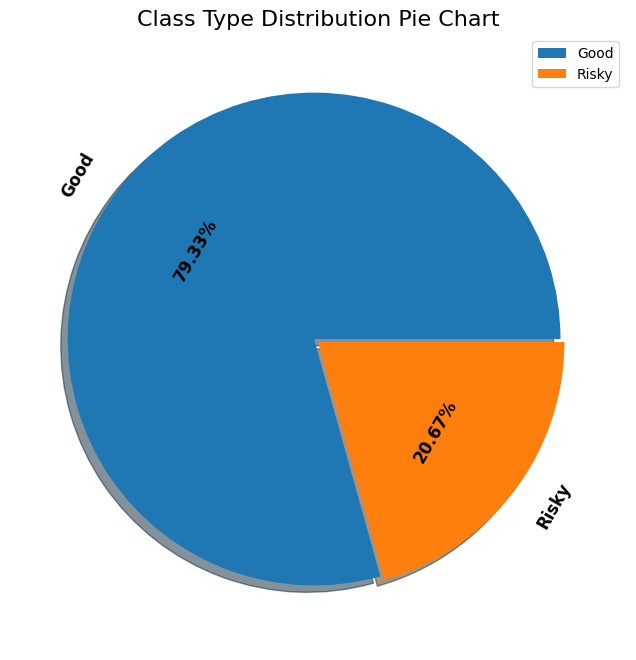

In [44]:
plt.figure(figsize = (12,8))
plt.pie(fraud_check_new['Taxable.Category'].value_counts(), labels= fraud_check_new['Taxable.Category'].unique(),
       explode = [0.02,0.0], autopct= '%.2f%%', shadow= True, startangle= 0,
       textprops = {'size':'large', 'fontweight':'bold', 'rotation': 60, 'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 16)
plt.show()



*   Good Class = **Majority Class**
*   Risky Class = **Minority Class**



In [45]:
countNotermdeposit = len(fraud_check_new[fraud_check_new['Taxable.Category'] == 'Good'])
counthavetermdeposit = len(fraud_check_new[fraud_check_new['Taxable.Category'] == 'Risky'])
print("Percentage of Customer doesn't have a term deposit: {:.2f}%".format((countNotermdeposit / (len(fraud_check_new['Taxable.Category']))*100)))
print("Percentage of Customer have a term deposit: {:.2f}%".format((counthavetermdeposit / (len(fraud_check_new['Taxable.Category'])))))

Percentage of Customer doesn't have a term deposit: 79.33%
Percentage of Customer have a term deposit: 0.21%


In [46]:
fraud_check_new['Taxable.Category'].value_counts()

Good     476
Risky    124
Name: Taxable.Category, dtype: int64

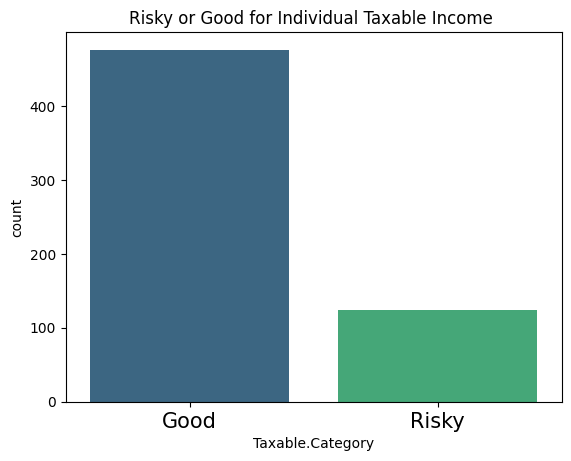

In [48]:
sns.countplot(x='Taxable.Category', data= fraud_check_new, palette = 'viridis', 
              order=fraud_check_new['Taxable.Category'].value_counts().index)
plt.xticks(fontsize = 15)
plt.title('Risky or Good for Individual Taxable Income ')
plt.show()

In [49]:
#Feature_Selection

fraud_check_new.columns

Index(['Undergrad', 'Marital.Status', 'Taxable.Income', 'City.Population',
       'Work.Experience', 'Urban', 'Taxable.Category'],
      dtype='object')

In [50]:
fraud_check_new_2 = fraud_check_new.copy()
fraud_check_new_2.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','City.Population':'City_Population','Work.Experience':'Work_Experience','Taxable.Category':'Taxable_Category'}, inplace = True)
fraud_check_new_2.drop('Taxable_Income', axis=1, inplace = True)
fraud_check_new_2.columns

Index(['Undergrad', 'Marital_Status', 'City_Population', 'Work_Experience',
       'Urban', 'Taxable_Category'],
      dtype='object')

In [51]:
categorical_features = fraud_check_new_2.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'Taxable_Category'], dtype='object')

In [52]:
#LabelEncoding

fraud_check_new_2.columns

Index(['Undergrad', 'Marital_Status', 'City_Population', 'Work_Experience',
       'Urban', 'Taxable_Category'],
      dtype='object')

In [55]:
le = LabelEncoder()
for column in categorical_features:
    le.fit(fraud_check_new_2[column])
    fraud_check_new_2[column] = le.transform(fraud_check_new_2[column])
fraud_check_new_2.head(10)

,Undergrad,Marital_Status,City_Population,Work_Experience,Urban,Taxable_Category
0,0,2,50047,10,1,0
1,1,0,134075,18,1,0
2,0,1,160205,30,1,0
3,1,2,193264,15,1,0
4,0,1,27533,28,0,0
5,0,0,116382,0,0,0
6,0,0,80890,8,1,0
7,1,2,131253,3,1,0
8,0,2,102481,12,1,0
9,1,0,155482,4,1,0


In [56]:
#Feature_Selection_Technique

fraud_check_new_3 = fraud_check_new.copy()
fraud_check_new_3.drop('Taxable.Income',axis=1, inplace =True)
fraud_check_new_3 = pd.get_dummies(fraud_check_new_3.iloc[:,:-1])
fraud_check_new_3.head(10)

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,1,0,0,0,1,0,1
1,134075,18,0,1,1,0,0,0,1
2,160205,30,1,0,0,1,0,0,1
3,193264,15,0,1,0,0,1,0,1
4,27533,28,1,0,0,1,0,1,0
5,116382,0,1,0,1,0,0,1,0
6,80890,8,1,0,1,0,0,0,1
7,131253,3,0,1,0,0,1,0,1
8,102481,12,1,0,0,0,1,0,1
9,155482,4,0,1,1,0,0,0,1


In [57]:
fraud_check_new_3['Taxable_Income'] = fraud_check_new['Taxable.Category']
fraud_check_new_3.head(10)

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,1,0,1,Good
1,134075,18,0,1,1,0,0,0,1,Good
2,160205,30,1,0,0,1,0,0,1,Good
3,193264,15,0,1,0,0,1,0,1,Good
4,27533,28,1,0,0,1,0,1,0,Good
5,116382,0,1,0,1,0,0,1,0,Good
6,80890,8,1,0,1,0,0,0,1,Good
7,131253,3,0,1,0,0,1,0,1,Good
8,102481,12,1,0,0,0,1,0,1,Good
9,155482,4,0,1,1,0,0,0,1,Good


In [58]:
le = LabelEncoder()
le.fit(fraud_check_new_3["Taxable_Income"])
fraud_check_new_3["Taxable_Income"]=le.transform(fraud_check_new_3["Taxable_Income"])
fraud_check_new_3.head(10)

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,1,0,1,0
1,134075,18,0,1,1,0,0,0,1,0
2,160205,30,1,0,0,1,0,0,1,0
3,193264,15,0,1,0,0,1,0,1,0
4,27533,28,1,0,0,1,0,1,0,0
5,116382,0,1,0,1,0,0,1,0,0
6,80890,8,1,0,1,0,0,0,1,0
7,131253,3,0,1,0,0,1,0,1,0
8,102481,12,1,0,0,0,1,0,1,0
9,155482,4,0,1,1,0,0,0,1,0


In [59]:
#Split Into Input(X) and Output(Y) Variable
x = fraud_check_new_3.iloc[:, :-1]
y=  fraud_check_new_3.Taxable_Income

In [60]:
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(x, y)

In [61]:
scores = fit.scores_
features = fit.transform(x)

In [62]:
scores_fraud_check = pd.DataFrame(list(zip(x.columns, scores)), columns =['Feature','Score'])
scores_fraud_check.sort_values(by="Score", ascending=False, inplace=True)
scores_fraud_check

,Feature,Score
0,City.Population,2045.643886
5,Marital.Status_Married,0.756912
4,Marital.Status_Divorced,0.302172
6,Marital.Status_Single,0.095850
2,Undergrad_NO,0.048929
3,Undergrad_YES,0.045165
1,Work.Experience,0.011709
7,Urban_NO,0.007044
8,Urban_YES,0.006951


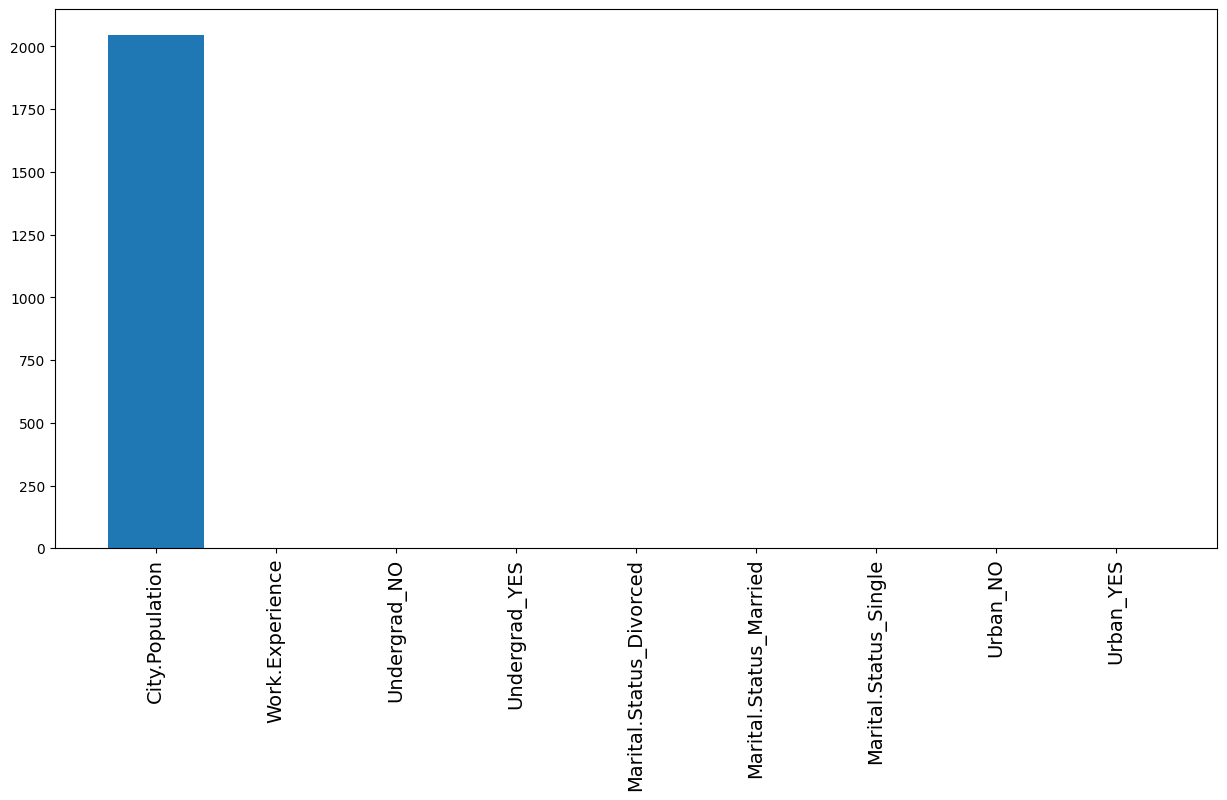

In [63]:
fig, axes = plt.subplots(figsize=(15,7))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation = 90, size = 14)
plt.show()

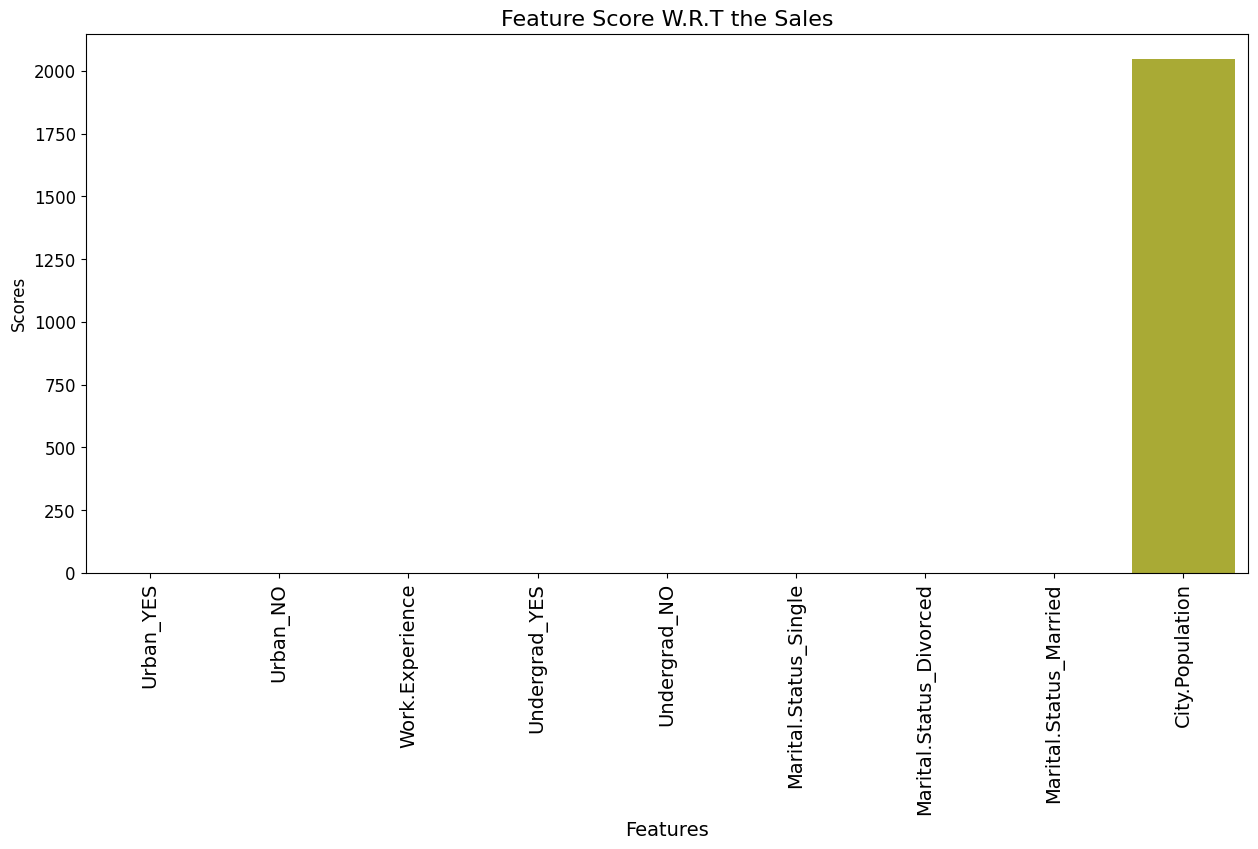

In [65]:
plt.figure(figsize=(15,7))
sns.barplot(x='Feature', y="Score", data=scores_fraud_check, order=scores_fraud_check.sort_values('Score').Feature)
plt.xlabel("Features", size=14)
plt.ylabel("Scores", size=12)
plt.yticks(rotation = 0, fontsize = 12)
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Feature Score W.R.T the Sales", size=16)
plt.show()

## **Random Forest Built In Feature Importance**

In [101]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)
rf_classifier.fit(x, y)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {'max_depth': [2,3,5,10,20], 'min_samples_leaf': [5,10,20,50,100,200],'n_estimators': [10,25,30,50,100,200]}

grid_search = GridSearchCV(estimator= rf, param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(x, y)
rf_best = grid_search.best_estimator_

print('Checking the oob score :', rf_classifier.oob_score_)
print('Best Score             :', grid_search.best_score_)
print('RF Best Model          :', rf_best)

Fitting 4 folds for each of 180 candidates, totalling 720 fits
Checking the oob score : 0.7933333333333333
Best Score             : 0.7933333333333333
RF Best Model          : RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1, random_state=42)


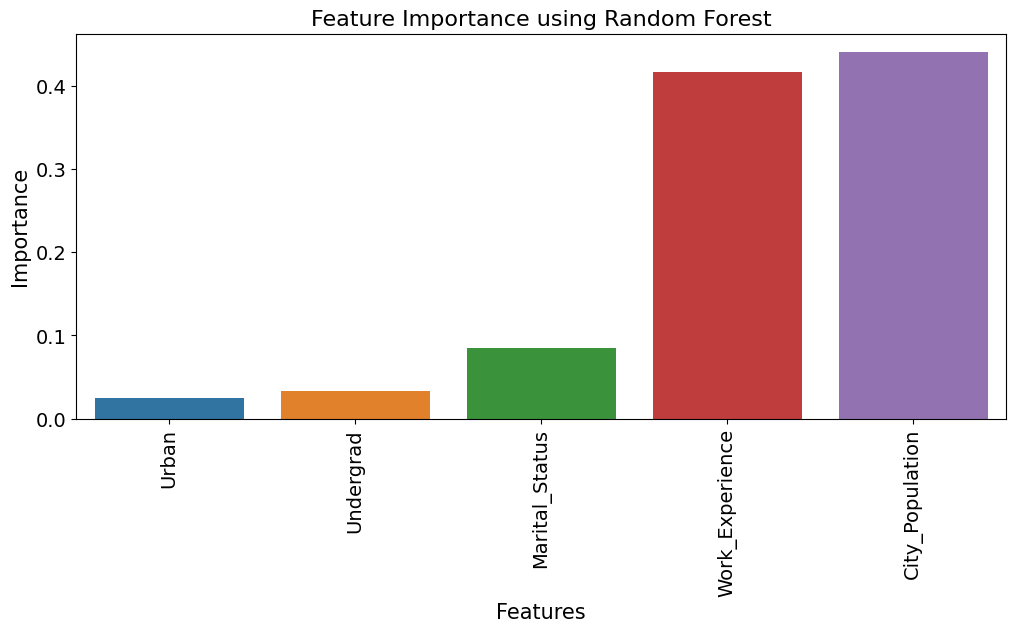

In [102]:
#Sorting Data With Help of Feature Importance

rf_best.feature_importances_
imp_df = pd.DataFrame({"Feature": x.columns, "Importance": rf_best.feature_importances_})

plt.figure(figsize=(12,5))
sns.barplot(x= 'Feature', y= "Importance", data= imp_df, order= imp_df.sort_values('Importance').Feature)
plt.xlabel("Features", size=15)
plt.ylabel("Importance", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Feature Importance using Random Forest", size=16)
plt.show()

In [103]:
#Train_Test Split with Imabalanced Data
x = fraud_check_new_2.drop('Taxable_Category',axis=1)
y = fraud_check_new_2['Taxable_Category']

In [104]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [105]:
print("Shape of x_train : ",x_train.shape)
print("Shape of x_test  : ",x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of x_train :  (420, 5)
Shape of x_test  :  (180, 5)
Shape of y_train :  (420,)
Shape of y_test  :  (180,)


In [106]:
#StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [107]:
for train_ix, test_ix in skf.split(x, y):

    train_x, test_x = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]

counter_train = Counter(train_y)
counter_test = Counter(test_y)
print('Training Data :',counter_train)
print('Testing Data  :',counter_test)

Training Data : Counter({0: 429, 1: 111})
Testing Data  : Counter({0: 47, 1: 13})


In [108]:
#Grid Search Using StratifiedKFold

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n------------------------------------------------>")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n------------------------------------------------->")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [109]:
rf_clf1 = RandomForestClassifier(n_estimators=100)
rf_clf1.fit(train_x, train_y)

print_score(rf_clf1, train_x, train_y, test_x, test_y, train=True)
print_score(rf_clf1, train_x, train_y, test_x, test_y, train=False)

Train Result:
------------------------------------------------>
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    429.0  111.0       1.0      540.0         540.0
_______________________________________________
Confusion Matrix: 
 [[429   0]
 [  0 111]]

Test Result:
------------------------------------------------->
Accuracy Score: 73.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0     1  accuracy  macro avg  weighted avg
precision   0.771930   0.0  0.733333   0.385965      0.604678
recall      0.936170   0.0  0.733333   0.468085      0.733333
f1-score    0.846154   0.0  0.733333   0.423077      0.662821
support    47.000000  13.0  0.733333  60.000000 

In [110]:
rf_clf2 = RandomForestClassifier(n_estimators=100)
rf_clf2.fit(x_train, y_train)

print_score(rf_clf2, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf2, x_train, y_train, x_test, y_test, train=False)

Train Result:
------------------------------------------------>
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1  accuracy  macro avg  weighted avg
precision    1.0   1.0       1.0        1.0           1.0
recall       1.0   1.0       1.0        1.0           1.0
f1-score     1.0   1.0       1.0        1.0           1.0
support    333.0  87.0       1.0      420.0         420.0
_______________________________________________
Confusion Matrix: 
 [[333   0]
 [  0  87]]

Test Result:
------------------------------------------------->
Accuracy Score: 76.11%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.790698   0.125000  0.761111    0.457849      0.653860
recall       0.951049   0.027027  0.761111    0.489038      0.761111
f1-score     0.863492   0.044444  0.761111    0.453968      0.695132
support    143.000000  37

**Due to Imbalanced Dataset our results are getting biased. the model is correctly performing classifying all major classes but it fails to classify the minor class**

# **SMOTE Techniques**

In [111]:
x = fraud_check_new_2.drop(['Taxable_Category'], axis=1)
y = fraud_check_new_2['Taxable_Category']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=0,stratify=y)

In [112]:
print("Shape of x_train : ",x_train.shape)
print("Shape of x_test  : ",x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of x_train :  (420, 5)
Shape of x_test  :  (180, 5)
Shape of y_train :  (420,)
Shape of y_test  :  (180,)


In [113]:
#SMOTE Oversampling 

counter = Counter(y_train)
print('Before',counter)
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 333})


In [114]:
#ADASYN

counter = Counter(y_train)
print('Before',counter)
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 327})


In [115]:
#Hybridization: SMOTE + Tomek Links

counter = Counter(y_train)
print('Before',counter)
smotomek = SMOTETomek(random_state=139)
x_train_smtom, y_train_smtom = smotomek.fit_resample(x_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 239, 1: 239})


In [116]:
# SMOTE + ENN

counter = Counter(y_train)
print('Before',counter)
smotenn = SMOTEENN()
x_train_smenn, y_train_smenn = smotenn.fit_resample(x_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({1: 87, 0: 86})


In [117]:
#Performance Analysis

sample_data = {'ACTUAL':[x_train, y_train], 'SMOTE':[x_train_sm, y_train_sm], 'ADASYN':[x_train_ada, y_train_ada],
               'SMOTE_TOMEK':[x_train_smtom, y_train_smtom], 'SMOTE_ENN':[x_train_smenn, y_train_smenn]}

In [118]:
def test_eval(clf_model, x_test, y_test, algo= None, sampling=None):

    # Test set prediction
    
    y_prob = clf_model.predict_proba(x_test)
    y_pred = clf_model.predict(x_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    
    f1        = f1_score(y_test, y_pred, average='micro')
    recall    = recall_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
          
    return algo,precision,recall,f1,sampling

In [119]:
model_params = {'random-forest' : {'model' : RandomForestClassifier(), 'params' : {"n_estimators": [5, 10, 15, 20, 25], 
                'max_depth': [i for i in range(5,16,2)], 'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
                'min_samples_leaf': [1, 2, 5], 'criterion': ['gini', 'entropy'], 'max_features': ['log2', 'sqrt', 'auto']}}}

In [121]:
cf = StratifiedKFold (n_splits=5, random_state=100, shuffle=True)
output = []
for model , model_hp in model_params.items():
    for resampl , data in sample_data.items():
        clf3 = RandomizedSearchCV (model_hp['model'], model_hp['params'], cv = cf, scoring='roc_auc', n_jobs=-1 )
        clf3.fit(data[0], data[1])
        clf_best1 = clf3.best_estimator_
        print('='*60)
        print(model+' with ' + resampl)
        print('-'*60)
        output.append(test_eval(clf_best1, x_test, y_test, model, resampl))

random-forest with ACTUAL
------------------------------------------------------------
Confusion Matrix
[[125  18]
 [ 33   4]] 

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       143
           1       0.18      0.11      0.14        37

    accuracy                           0.72       180
   macro avg       0.49      0.49      0.48       180
weighted avg       0.67      0.72      0.69       180
 

random-forest with SMOTE
------------------------------------------------------------
Confusion Matrix
[[100  43]
 [ 27  10]] 

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       143
           1       0.19      0.27      0.22        37

    accuracy                           0.61       180
   macro avg       0.49      0.48      0.48       180
weighted avg       0.66      0.61      0.63       180
 

random-forest with ADASYN
---------------

In [122]:
counter = Counter(y_train)
print('Before',counter)
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 327})


In [123]:
x_train,x_test,y_train,y_test = train_test_split(x_train_ada,y_train_ada,test_size=0.3,random_state=0, stratify=y_train_ada)

counter = Counter(y_train)
print('Train Counter    : ',counter)
counter = Counter(y_test)
print('Test Counter     : ',counter)
print("Shape of X_train : ",x_train.shape)
print("Shape of X_test  : ", x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Train Counter    :  Counter({0: 233, 1: 229})
Test Counter     :  Counter({0: 100, 1: 98})
Shape of X_train :  (462, 5)
Shape of X_test  :  (198, 5)
Shape of y_train :  (462,)
Shape of y_test  :  (198,)


## **Random Forest Hyperparameter Tuning**

In [125]:
scores_array = []
for each in range(1,200):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 10) 
    rf_loop.fit(x_train,y_train)
    scores_array.append(rf_loop.score(x_test,y_test))

In [126]:
loc = np.array(scores_array).max()
scores_array.index(loc)+1

18

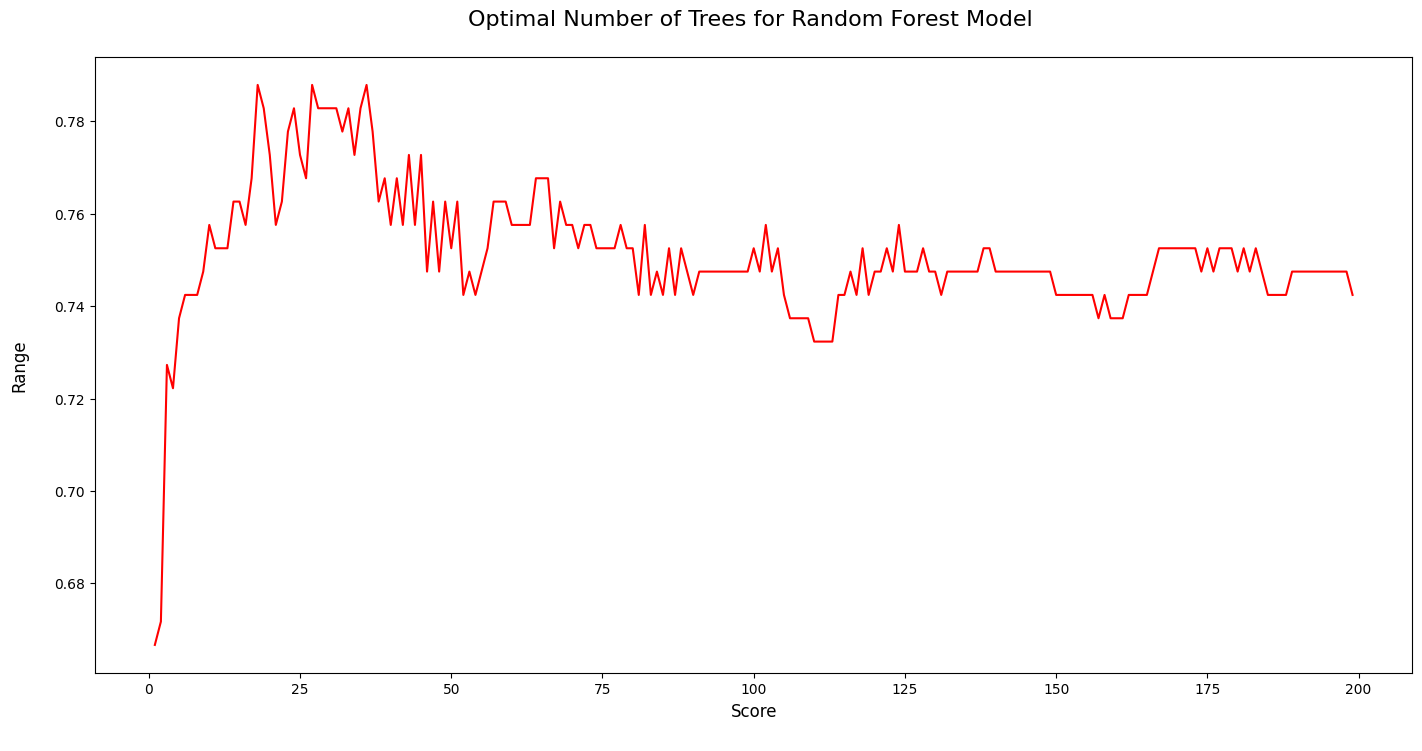

In [128]:
fig = plt.figure(figsize=(17, 8))
plt.plot(range(1,200),scores_array, color = 'r')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontsize = "16")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

In [129]:
# Randomized Search Cross Validation

n_estimators = [int(x) for x in np.linspace(start=0, stop=200, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(x_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best paramters: {'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True})
Train Result:
------------------------------------------------>
Accuracy Score: 93.29%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.950893    0.915966    0.9329    0.933430      0.933581
recall       0.914163    0.951965    0.9329    0.933064      0.932900
f1-score     0.932166    0.933619    0.9329    0.932893      0.932886
support    233.000000  229.000000    0.9329  462.000000    462.000000
_______________________________________________
Confusion Matrix: 
 [[213  20]
 [ 11 218]]

Test Result:
------------------------------------------------->
Accuracy Score: 72.22%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  

In [130]:
#Grid Search Cross Validation

pipe_rfc = Pipeline([('scl', StandardScaler()), ('rfc', RandomForestClassifier(random_state=0, n_jobs=-1) )])
param_grid_rfc =  [{'rfc__n_estimators': [100, 200,300,400], 'rfc__max_features':[0.05 , 0.1],
                    'rfc__max_depth': [None, 5], 'rfc__min_samples_split': [0.005, 0.01]}]

kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state= 0)
grid_rfc = GridSearchCV(pipe_rfc, param_grid= param_grid_rfc, cv=kfold, scoring='f1', verbose= 1, n_jobs=-1)

start = time()
grid_rfc = grid_rfc.fit(x_train, y_train)
end = time()

print("RFC grid search took %.3f seconds" %(end-start))
print('<-------Best score---------->')
print(grid_rfc.best_score_ * 100.0)
print('<-------Best params---------->')
print(grid_rfc.best_params_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
RFC grid search took 153.773 seconds
-------Best score----------
70.38844506088265
-------Best params----------
{'rfc__max_depth': None, 'rfc__max_features': 0.05, 'rfc__min_samples_split': 0.005, 'rfc__n_estimators': 400}


In [131]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=60, random_state=42)

In [132]:
fraud_check_new['Taxable.Category'].unique()

['Good', 'Risky']
Categories (2, object): ['Risky' < 'Good']

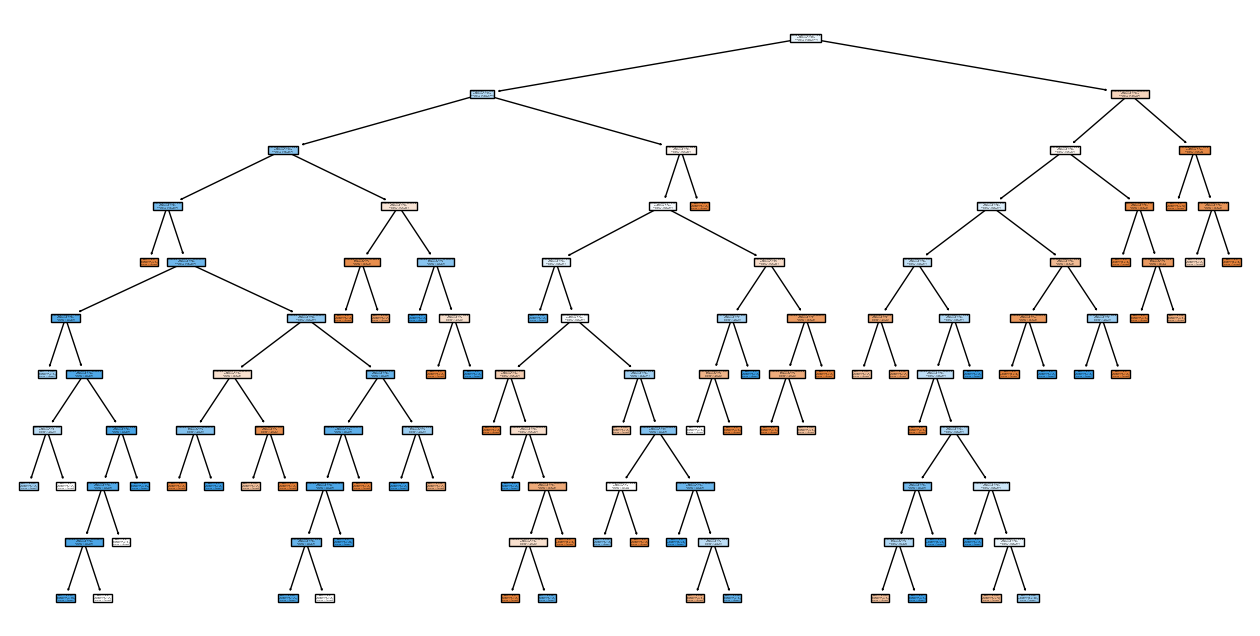

In [133]:
plt.figure(figsize=(16,8))
plot_tree(rf_best.estimators_[59], feature_names = fraud_check.columns,class_names=fraud_check_new['Taxable.Category'].unique(),filled=True)
plt.show()

# **Model Deployement**

In [134]:
from pickle import dump

In [135]:
dump(rf_clf, open('fraud_check_intell.pkl','wb'))